In [29]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [30]:
!pip install wandb
import wandb
from wandb.keras import WandbCallback

In [31]:
# Installing pre-requisite for saving the model
!pip install pyyaml h5py

In [32]:
# Mount google drive where dataset is stored at
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
# Import necessary libraries
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.applications.resnet_v2 import preprocess_input, decode_predictions
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, BatchNormalization, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd

In [34]:
# Configuration settings 
configs = {
    'epochs': 20,
    'batch_size': 32, 
    'seed': 7,
    'learning_rate': [1e-1, 1e-3, 3e-4, 1e-5],
    'hidden_activation': 'relu',
    'output_activation': 'sigmoid',
    'optimizer': 'adam',
    'loss_function': 'binary_crossentropy',
    'metrics': ['accuracy'],
    'fc_layer_1_neurons' : 1024,
    'fc_layer_2_neurons' : 512,
    'fc_layer_3_neurons' : 256,
}

# Initialise Wandb
learning_rate_tuning = wandb.init(
    name='resnet50V2_learning_rate',
    project='CZ4042_Assignment_2_Hyperparameter_Tuning',
    config= configs,
)

config = wandb.config
tf.random.set_seed(config.seed)

In [35]:
# Define the google drive path where data is stored
base_path = '/content/drive/MyDrive/CZ4042 Project Assignment 2/Models/'

# Load preprocessed dataset containing image path and gender as dataframe
df = pd.read_csv(base_path + 'processed_path_and_gender.txt', sep='\t')

# Split the dataset 80% train / 20% test
train_df, test_df = train_test_split(df, test_size=0.2, random_state = config.seed)

# Append the google drive path infront of the image path 
train_df['data_path'] = base_path + train_df['data_path'].astype(str)
test_df['data_path'] = base_path + test_df['data_path'].astype(str)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


In [36]:
# Creating the resnet50V2 model
def get_resnet50V2_model():

  seq = tf.keras.models.Sequential()

  seq.add(ResNet50V2(include_top=False, pooling = 'avg', weights ='imagenet', input_shape=(224,224,3)))

  seq.add(Flatten())

  seq.add(BatchNormalization())

  seq.add(Dense(config.fc_layer_1_neurons, activation = config.hidden_activation))

  seq.add(BatchNormalization())

  seq.add(Dense(config.fc_layer_2_neurons, activation = config.hidden_activation))

  seq.add(BatchNormalization())

  seq.add(Dense(config.fc_layer_3_neurons, activation = config.hidden_activation))

  seq.add(BatchNormalization())

  seq.add(Dense(1, activation= config.output_activation))
  
  seq.layers[0].trainable = False

  return seq

In [37]:
model = get_resnet50V2_model()

# View summary of model
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
 flatten_4 (Flatten)         (None, 2048)              0         
                                                                 
 batch_normalization_16 (Bat  (None, 2048)             8192      
 chNormalization)                                                
                                                                 
 dense_16 (Dense)            (None, 1024)              2098176   
                                                                 
 batch_normalization_17 (Bat  (None, 1024)             4096      
 chNormalization)                                                
                                                                 
 dense_17 (Dense)            (None, 512)              

In [38]:
historyArr = []
meanAccArr = []

# Initialise ImageDataGenerator 
# Perform rescaling using resnet50V2's preprocess_input method
train_image_generated = ImageDataGenerator(preprocessing_function = preprocess_input)
test_image_generated = ImageDataGenerator(preprocessing_function = preprocess_input)

def train_model(var_learning_rate):
  model = get_resnet50V2_model()
  
  # Generate the rescaled train images from the dataframe given 
  train_ds = train_image_generated.flow_from_dataframe(
      dataframe = train_df,
      x_col ='data_path',
      y_col = 'gender',
      batch_size = config.batch_size,
      seed = config.seed,
      shuffle = True,
      class_mode ='raw',
      target_size = (224,224),
  )

  # Generate the rescaled test images from the dataframe given 
  test_ds = test_image_generated.flow_from_dataframe(
      dataframe = test_df,
      x_col = 'data_path',
      y_col = 'gender',
      batch_size = config.batch_size,
      seed = config.seed,
      shuffle = True,
      class_mode = 'raw',
      target_size = (224,224),
  )

  # Compile the model
  train_history = model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=var_learning_rate),
    loss = config.loss_function,
    metrics = config.metrics,
  )

  # Checkpoint storing path
  checkpoint_path = base_path + "Model Checkpoints/" + "resnet50V2_cp.ckpt"
  checkpoint_dir = os.path.dirname(checkpoint_path)

  # Model checkpoint to store best weights
  model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
      filepath= checkpoint_path,
      save_weights_only=True,
      monitor='val_accuracy',
      mode='max',
      save_best_only=True)

  # Training the model
  train_history = model.fit(
      train_ds,
      epochs= config.epochs,
      use_multiprocessing=True,
      callbacks=[WandbCallback()],
      validation_data=test_ds,
  )
  
  meanAcc = np.mean(train_history.history['val_accuracy'], axis = 0)
  print("\n")
  
  return meanAcc, train_history

In [39]:
for lr in config.learning_rate:
  print("Learning Rate: ", lr)
  meanAcc_, history_ = train_model(lr)
  meanAccArr.append(meanAcc_)
  historyArr.append(history_)

Learning Rate:  0.1
Found 9755 validated image filenames.
Found 2439 validated image filenames.
Epoch 1/20
305/305 [==============================] - ETA: 0s - loss: 0.5145 - accuracy: 0.7981

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


305/305 [==============================] - 3658s 12s/step - loss: 0.5145 - accuracy: 0.7981 - val_loss: 1.0588 - val_accuracy: 0.6216
Epoch 2/20
305/305 [==============================] - 141s 462ms/step - loss: 0.3348 - accuracy: 0.8554 - val_loss: 2.3359 - val_accuracy: 0.5150
Epoch 3/20
305/305 [==============================] - 139s 454ms/step - loss: 0.3272 - accuracy: 0.8667 - val_loss: 0.7243 - val_accuracy: 0.7831
Epoch 4/20
305/305 [==============================] - 140s 460ms/step - loss: 0.2945 - accuracy: 0.8746 - val_loss: 0.3702 - val_accuracy: 0.8618
Epoch 5/20
305/305 [==============================] - 138s 453ms/step - loss: 0.3030 - accuracy: 0.8774 - val_loss: 139.4362 - val_accuracy: 0.5592
Epoch 6/20
305/305 [==============================] - 139s 455ms/step - loss: 0.2971 - accuracy: 0.8715 - val_loss: 8.6924 - val_accuracy: 0.8352
Epoch 7/20
305/305 [==============================] - 140s 458ms/step - loss: 0.2852 - accuracy: 0.8822 - val_loss: 199.1371 - val_acc

In [40]:
bestLearningRate = []
bestLearningRate.append(config.learning_rate[np.argmax(meanAccArr)])

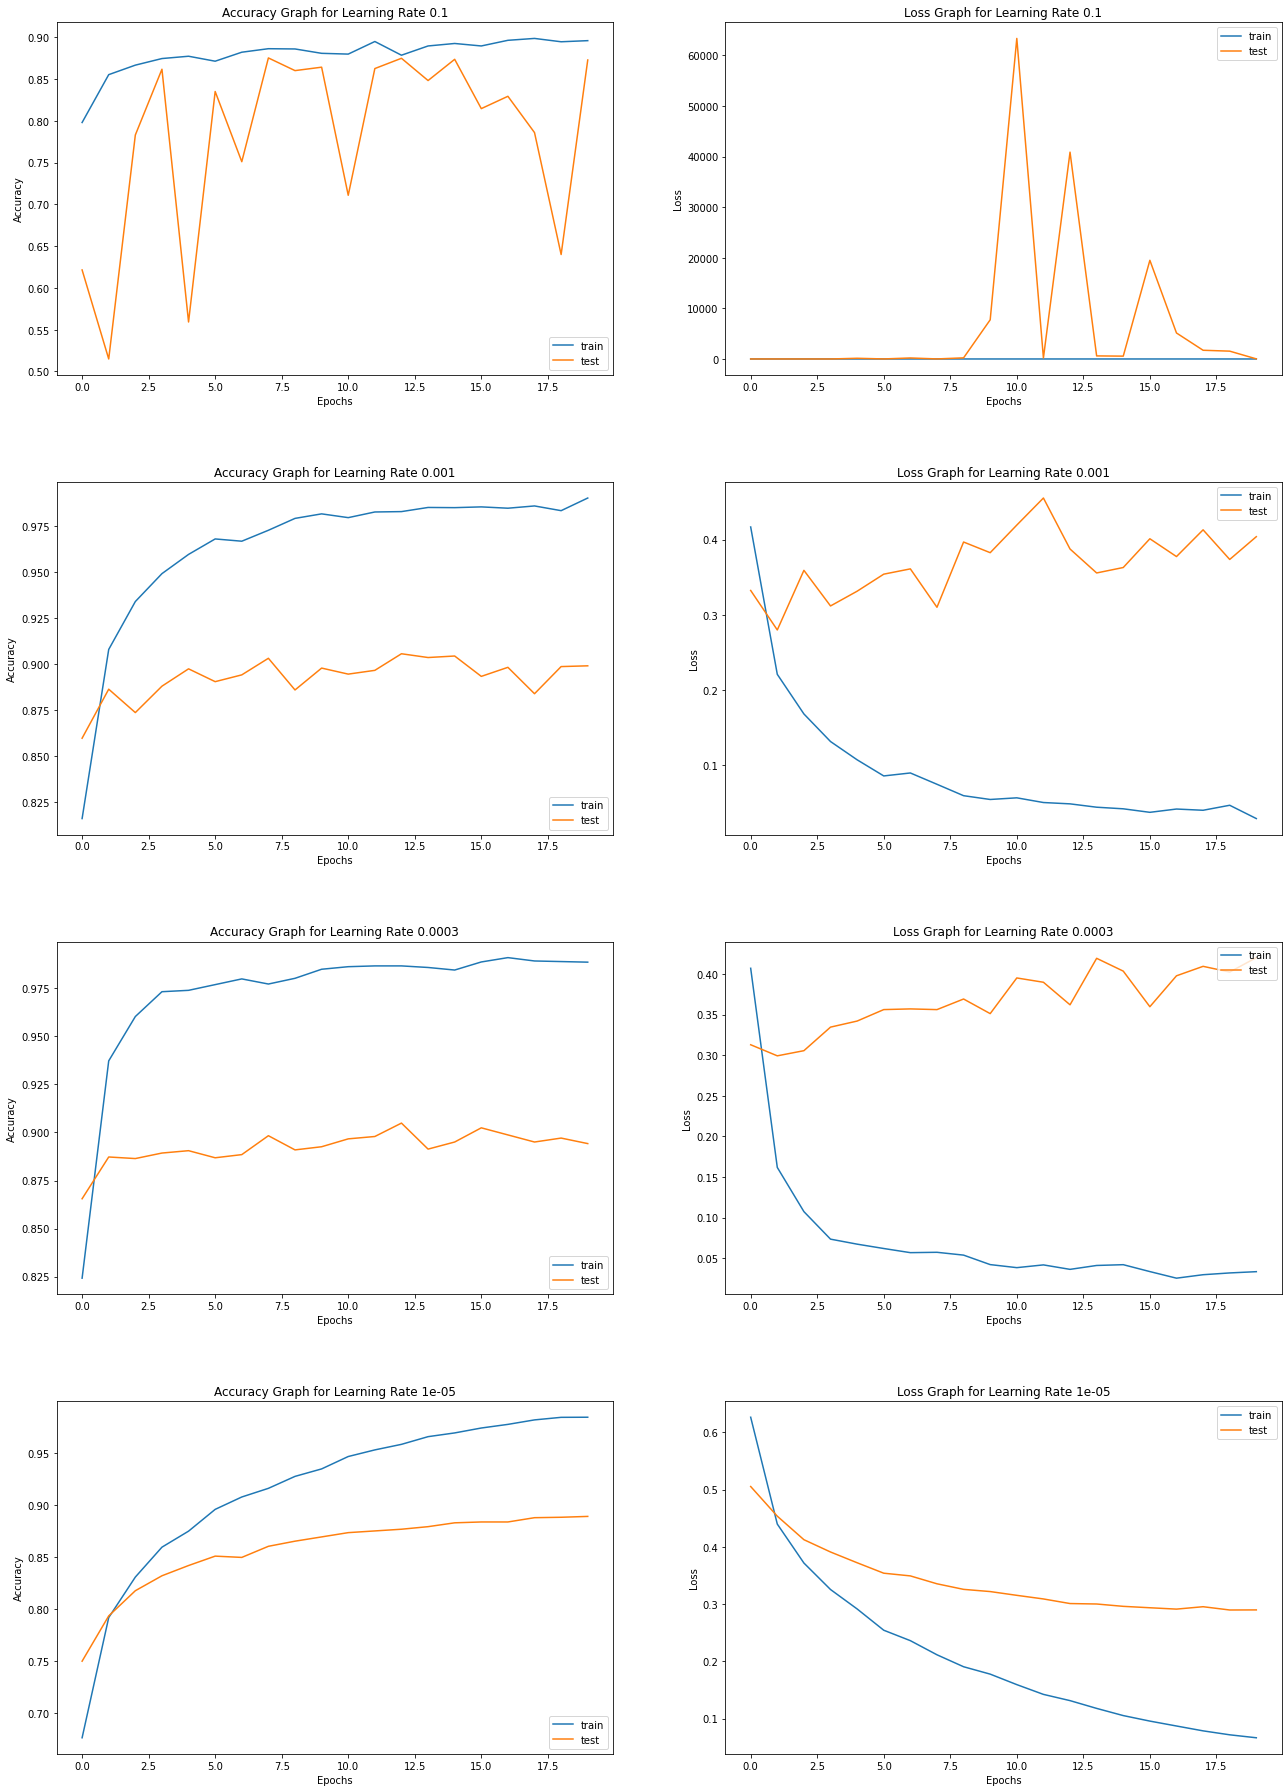

In [41]:
# Create plot spaces for (4x2) subplot with figure size of (18x25)
f, axes = plt.subplots(4, 2, figsize=(18, 25))

# Plotting the graphs to see accuracy and loss over epochs for the different learning rates selected (1e-1, 1e-3, 3e-4, 1e-5)
for i in range(len(config.learning_rate)):
    # Accuracy graph for the different learning rates
    axes[i,0].plot(historyArr[i].history['accuracy'])
    axes[i,0].plot(historyArr[i].history['val_accuracy'])
    axes[i,0].set_title('Accuracy Graph for Learning Rate ' + str(config.learning_rate[i]))
    axes[i,0].set(xlabel='Epochs', ylabel='Accuracy')
    axes[i,0].legend(['train', 'test'], loc='lower right')

    # Loss graph for the different learning rates
    axes[i,1].plot(historyArr[i].history['loss'])
    axes[i,1].plot(historyArr[i].history['val_loss'])
    axes[i,1].set_title('Loss Graph for Learning Rate ' + str(config.learning_rate[i]))
    axes[i,1].set(xlabel='Epochs', ylabel='Loss')
    axes[i,1].legend(['train', 'test'], loc='upper right')

# Spacing between each graph
f.tight_layout(h_pad=6, w_pad=6)

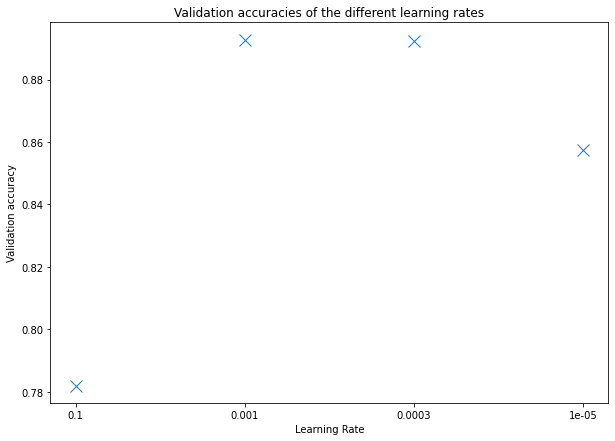

In [42]:
# Scatter plot of the validation accuracy for the different learning rates
plt.figure(figsize=(10, 7))
plt.title("Validation accuracies of the different learning rates")
plt.plot(meanAccArr, marker = 'x', linestyle = 'None', markersize=12)
plt.xticks(np.arange(4), [1e-1, 1e-3, 3e-4, 1e-5])
plt.xlabel('Learning Rate')
plt.ylabel('Validation accuracy')
plt.show()

In [43]:
for i in range(len(config.learning_rate)):
  print("Learning Rate: " + str(config.learning_rate[i]) + ", Mean Accuracy: " + str(meanAccArr[i]))

Learning Rate: 0.1, Mean Accuracy: 0.7820213198661804
Learning Rate: 0.001, Mean Accuracy: 0.892804428935051
Learning Rate: 0.0003, Mean Accuracy: 0.892476424574852
Learning Rate: 1e-05, Mean Accuracy: 0.8573800653219223


In [44]:
print(bestLearningRate)

[0.001]
